In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # Mean
        self.fc22 = nn.Linear(400, 20)  # Variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function: reconstruction + KL divergence losses
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True)

100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 13236899.43it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28448965.20it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8374422.73it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [3]:
# Instantiate VAE
vae = VAE()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
vae.train()
epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 549.740112
Train Epoch: 0 [12800/60000 (21%)]	Loss: 187.433167
Train Epoch: 0 [25600/60000 (43%)]	Loss: 155.615204
Train Epoch: 0 [38400/60000 (64%)]	Loss: 136.723373
Train Epoch: 0 [51200/60000 (85%)]	Loss: 134.869873
Train Epoch: 1 [0/60000 (0%)]	Loss: 128.508194
Train Epoch: 1 [12800/60000 (21%)]	Loss: 119.519402
Train Epoch: 1 [25600/60000 (43%)]	Loss: 126.186157
Train Epoch: 1 [38400/60000 (64%)]	Loss: 120.340714
Train Epoch: 1 [51200/60000 (85%)]	Loss: 118.956703
Train Epoch: 2 [0/60000 (0%)]	Loss: 116.407028
Train Epoch: 2 [12800/60000 (21%)]	Loss: 117.009811
Train Epoch: 2 [25600/60000 (43%)]	Loss: 119.456055
Train Epoch: 2 [38400/60000 (64%)]	Loss: 110.980133
Train Epoch: 2 [51200/60000 (85%)]	Loss: 112.057098
Train Epoch: 3 [0/60000 (0%)]	Loss: 114.160461
Train Epoch: 3 [12800/60000 (21%)]	Loss: 110.433136
Train Epoch: 3 [25600/60000 (43%)]	Loss: 110.060135
Train Epoch: 3 [38400/60000 (64%)]	Loss: 109.976326
Train Epoch: 3 [51200/60000 (85%

In [4]:

# Generating samples from the trained VAE
vae.eval()
with torch.no_grad():
    z_sample = torch.randn(64, 20)
    sample = vae.decode(z_sample).cpu()


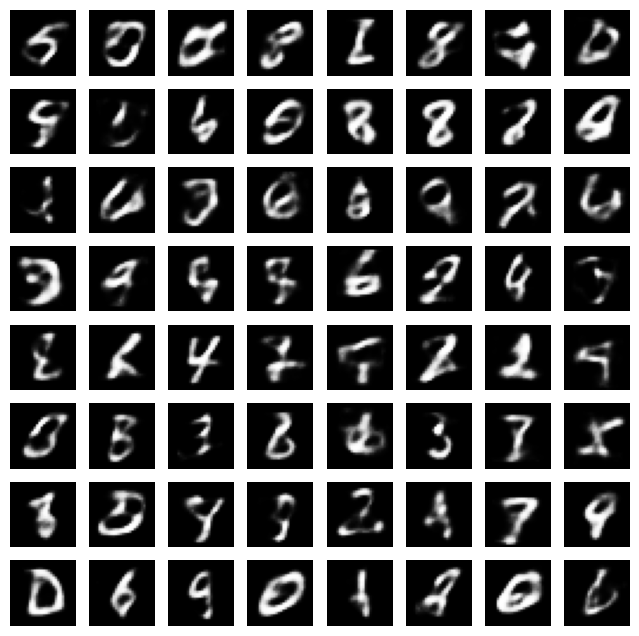

In [5]:

# Display some generated samples
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(sample[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
